In [ ]:
pathway = './'

In [0]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, BatchNormalization, \
                                    Conv1D, LSTM, GRU, Dropout, concatenate, Bidirectional, \
                                    TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [0]:
# Read sequence
X = []
with open(pathway + 'raw_data/features.dat', 'r') as f:
    for line in f:
        seq = list(line.strip('\n'))
        if len(seq) <= 700:
            X.append(seq)

Y_3types = []
with open(pathway + 'raw_data/labels_3types.dat', 'r') as f:
    for line in f:
        seq = list(line.strip('\n'))
        if len(seq) <= 700:
            Y_3types.append(seq)

In [0]:
# Create dictionary
source_token_dict = {'<PAD>': 0, 'R': 1, 'S': 2, 'P': 3, 'A': 4, 'D': 5, 'I': 6, 'K': 7, 'V': 8, 'H': 9, 'T': 10, 'E': 11, 'G': 12, 'L': 13, 'Q': 14, 'N': 15, 'M': 16, 'C': 17, 'Y': 18, 'F': 19, 'W': 20}
target_token_dict = {'<PAD>': 0, 'C': 1, 'E': 2, 'H': 3}
source_token_dict_inv = {0: '<PAD>', 1: 'R', 2: 'S', 3: 'P', 4: 'A', 5: 'D', 6: 'I', 7: 'K', 8: 'V', 9: 'H', 10: 'T', 11: 'E', 12: 'G', 13: 'L', 14: 'Q', 15: 'N', 16: 'M', 17: 'C', 18: 'Y', 19: 'F', 20: 'W'}
target_token_dict_inv = {0: '<PAD>', 1: 'C', 2: 'E', 3: 'H'}

In [0]:
# blosum62 matrix
blosum62 = {
    'A': [4,-1,-2,-2,0,-1,-1,0,-2,-1,-1,-1,-1,-2,-1,1,0,-3,-2,0,-2,-1,0,-4],
    'R': [-1,5,0,-2,-3,1,0,-2,0,-3,-2,2,-1,-3,-2,-1,-1,-3,-2,-3,-1,0,-1,-4],
    'N': [-2,0,6,1,-3,0,0,0,1,-3,-3,0,-2,-3,-2,1,0,-4,-2,-3,3,0,-1,-4],
    'D': [-2,-2,1,6,-3,0,2,-1,-1,-3,-4,-1,-3,-3,-1,0,-1,-4,-3,-3,4,1,-1,-4],
    'C': [0,-3,-3,-3,9,-3,-4,-3,-3,-1,-1,-3,-1,-2,-3,-1,-1,-2,-2,-1,-3,-3,-2,-4],
    'Q': [-1,1,0,0,-3,5,2,-2,0,-3,-2,1,0,-3,-1,0,-1,-2,-1,-2,0,3,-1,-4],
    'E': [-1,0,0,2,-4,2,5,-2,0,-3,-3,1,-2,-3,-1,0,-1,-3,-2,-2,1,4,-1,-4],
    'G': [0,-2,0,-1,-3,-2,-2,6,-2,-4,-4,-2,-3,-3,-2,0,-2,-2,-3,-3,-1,-2,-1,-4],
    'H': [-2,0,1,-1,-3,0,0,-2,8,-3,-3,-1,-2,-1,-2,-1,-2,-2,2,-3,0,0,-1,-4],
    'I': [-1,-3,-3,-3,-1,-3,-3,-4,-3,4,2,-3,1,0,-3,-2,-1,-3,-1,3,-3,-3,-1,-4],
    'L': [-1,-2,-3,-4,-1,-2,-3,-4,-3,2,4,-2,2,0,-3,-2,-1,-2,-1,1,-4,-3,-1,-4],
    'K': [-1,2,0,-1,-3,1,1,-2,-1,-3,-2,5,-1,-3,-1,0,-1,-3,-2,-2,0,1,-1,-4],
    'M': [-1,-1,-2,-3,-1,0,-2,-3,-2,1,2,-1,5,0,-2,-1,-1,-1,-1,1,-3,-1,-1,-4],
    'F': [-2,-3,-3,-3,-2,-3,-3,-3,-1,0,0,-3,0,6,-4,-2,-2,1,3,-1,-3,-3,-1,-4],
    'P': [-1,-2,-2,-1,-3,-1,-1,-2,-2,-3,-3,-1,-2,-4,7,-1,-1,-4,-3,-2,-2,-1,-2,-4],
    'S': [1,-1,1,0,-1,0,0,0,-1,-2,-2,0,-1,-2,-1,4,1,-3,-2,-2,0,0,0,-4],
    'T': [0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,1,5,-2,-2,0,-1,-1,0,-4],
    'W': [-3,-3,-4,-4,-2,-2,-3,-2,-2,-3,-2,-3,-1,1,-4,-3,-2,11,2,-3,-4,-3,-2,-4],
    'Y': [-2,-2,-2,-3,-2,-1,-2,-3,2,-1,-1,-2,-1,3,-3,-2,-2,2,7,-1,-3,-2,-1,-4],
    'V': [0,-3,-3,-3,-1,-2,-2,-3,-3,3,1,-2,1,-1,-2,-2,0,-3,-1,4,-3,-2,-1,-4],
    'B': [-2,-1,3,4,-3,0,1,-1,0,-3,-4,0,-3,-3,-2,0,-1,-4,-3,-3,4,1,-1,-4],
    'Z': [-1,0,0,1,-3,3,4,-2,0,-3,-3,1,-1,-3,-1,0,-1,-3,-2,-2,1,4,-1,-4],
    'X': [0,-1,-1,-1,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-2,0,0,-2,-1,-1,-1,-1,-1,-4],
    '*': [-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,1],
    '<PAD>': [-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,1]
}

In [0]:
# Padding
source_max_len = max(map(len, X))
target_max_len = max(map(len, Y_3types))

primar_tokens = [tokens + ['<PAD>'] * (source_max_len - len(tokens)) for tokens in X]
secstr_tokens = [tokens + ['<PAD>'] * (target_max_len - len(tokens)) for tokens in Y_3types]

primar_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in primar_tokens]
secstr_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in secstr_tokens]

primar_blo = [list(map(lambda x: blosum62[x], tokens)) for tokens in primar_tokens]

In [0]:
primar_final = np.concatenate((to_categorical(np.array(primar_input)),np.array(primar_blo)), axis=-1)
secstr_final = np.array(secstr_input)

In [0]:
# Build model
n_classes = len(target_token_dict)
prime_length = source_max_len
prime_token_num = len(source_token_dict) + len(blosum62['A'])
dropout_rate = 0.5

# Input, embedding and batch normalize
main_input = Input(shape=(None, prime_token_num), name='Primary-Input')
main_batchNorm = BatchNormalization(name='Batch-Normalization')(main_input)

# Inception like layers
conv_layer_1_1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-1_1')(main_batchNorm)
conv_layer_2_1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-2_1')(main_batchNorm)
conv_layer_3_1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-3_1')(main_batchNorm)
conv_layer_4_1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-4_1')(main_batchNorm)
conv_layer_2_2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-2_2')(conv_layer_2_1)
conv_layer_3_2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-3_2')(conv_layer_3_1)
conv_layer_4_2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-4_2')(conv_layer_4_1)
conv_layer_3_3 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-3_3')(conv_layer_3_2)
conv_layer_4_3 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-4_3')(conv_layer_4_2)
conv_layer_4_4 = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Conv1D-4_4')(conv_layer_4_3)
concat_conv = concatenate([main_batchNorm, conv_layer_1_1, conv_layer_2_2, conv_layer_3_3, conv_layer_4_4], name='Conv-Concate')

# Dropout, dense and batch normalize
dropout_layer = Dropout(rate=dropout_rate, name='Dropout-Conv')(concat_conv)
dense_layer = Dense(units=256, activation='relu', name='Dense-Conv')(dropout_layer)
hidden_batchNorm = BatchNormalization(name='Hidden-Batch-Normalization')(dense_layer)

# Bi-directional LSTM and GRU
lstm_layer = Bidirectional(LSTM(units=256, return_sequences=True, name='Bidirect-LSTM'))(hidden_batchNorm)
gru_layer = Bidirectional(GRU(units=256, return_sequences=True, name='Bidirect-GRU'))(dense_layer)
dropout_lstm = Dropout(rate=dropout_rate, name='Dropout-LSTM')(lstm_layer)
dropout_gru = Dropout(rate=dropout_rate, name='Dropout-GRU')(gru_layer)
concate_cnn_lstm_gru = concatenate([dense_layer, dropout_lstm, dropout_gru], name='All-Concate')
dense_out = Dense(units=256, activation='relu')(concate_cnn_lstm_gru)
#dense_out = Dense(units=dense_size, activation='relu')(dense_batchNorm)

#Final TimeDistri
timedistri_layer = TimeDistributed(Dense(units=n_classes, activation='softmax'))(dense_out)

In [0]:
model = Model(inputs=main_input, outputs=timedistri_layer)

In [0]:
model.load_weights(pathway + 'improved-model_weights.h5')

In [0]:
test_self = model.predict(primar_final)

In [0]:
test_self = np.argmax(test_self, axis=-1)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
cnf_matrix = confusion_matrix(secstr_final.flatten(), test_self.flatten(), labels=[0, 1, 2, 3])

Confusion matrix, without normalization
[[6848004       0       0       0]
 [      0 1241367  176880  164373]
 [      0  150092  590355   19572]
 [      0  197020   29285 1051552]]


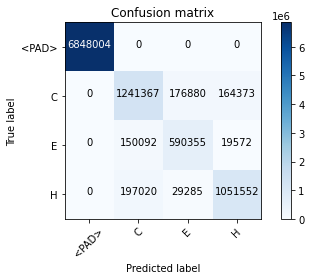

In [15]:
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['<PAD>', 'C', 'E', 'H'],
                      title='Confusion matrix')

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.78 0.11 0.1 ]
 [0.   0.2  0.78 0.03]
 [0.   0.15 0.02 0.82]]


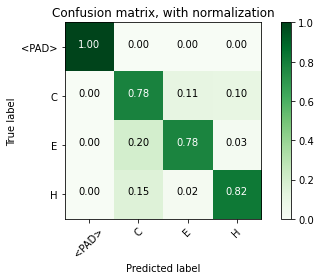

In [16]:
plot_confusion_matrix(cnf_matrix, classes=['<PAD>', 'C', 'E', 'H'], normalize=True,
                      title='Confusion matrix, with normalization', cmap=plt.cm.Greens)